hu1 =  [array([2.16737178e-03, 1.19677346e-06, 1.66671654e-10, 1.13235800e-10,
       1.15796626e-20, 6.70454289e-14, 1.03879785e-20]), array([ 1.17075871e-03,  1.41750398e-07,  3.08528318e-12,  2.90746412e-12,
        8.06507961e-24,  1.07535157e-15, -3.28389693e-24]), array([1.22288515e-03, 2.04187369e-07, 2.32645851e-12, 3.42280445e-12,
       8.26739135e-24, 1.53848066e-15, 4.99415988e-24]), array([ 1.24238910e-03,  1.46775765e-07,  9.09073458e-13,  6.15364367e-12,
       -1.18653361e-23,  9.57538201e-16, -8.42899555e-24]), array([ 1.20289744e-03,  4.47401896e-07,  7.29338380e-12,  1.40625455e-11,
        1.24501234e-22,  9.21419620e-15, -6.91513920e-23]), array([ 1.15815490e-03,  2.40809795e-07,  1.18611748e-13,  5.05946867e-14,
        3.78516953e-27,  1.61136521e-18, -1.01700710e-27]), array([ 1.23887492e-03,  2.56000979e-08,  7.36440243e-13,  1.12003729e-12,
        6.45498479e-25,  2.37964496e-17, -7.86181003e-25]), array([1.19977735e-03, 8.43135082e-08, 5.84397438e-12, 2.0363

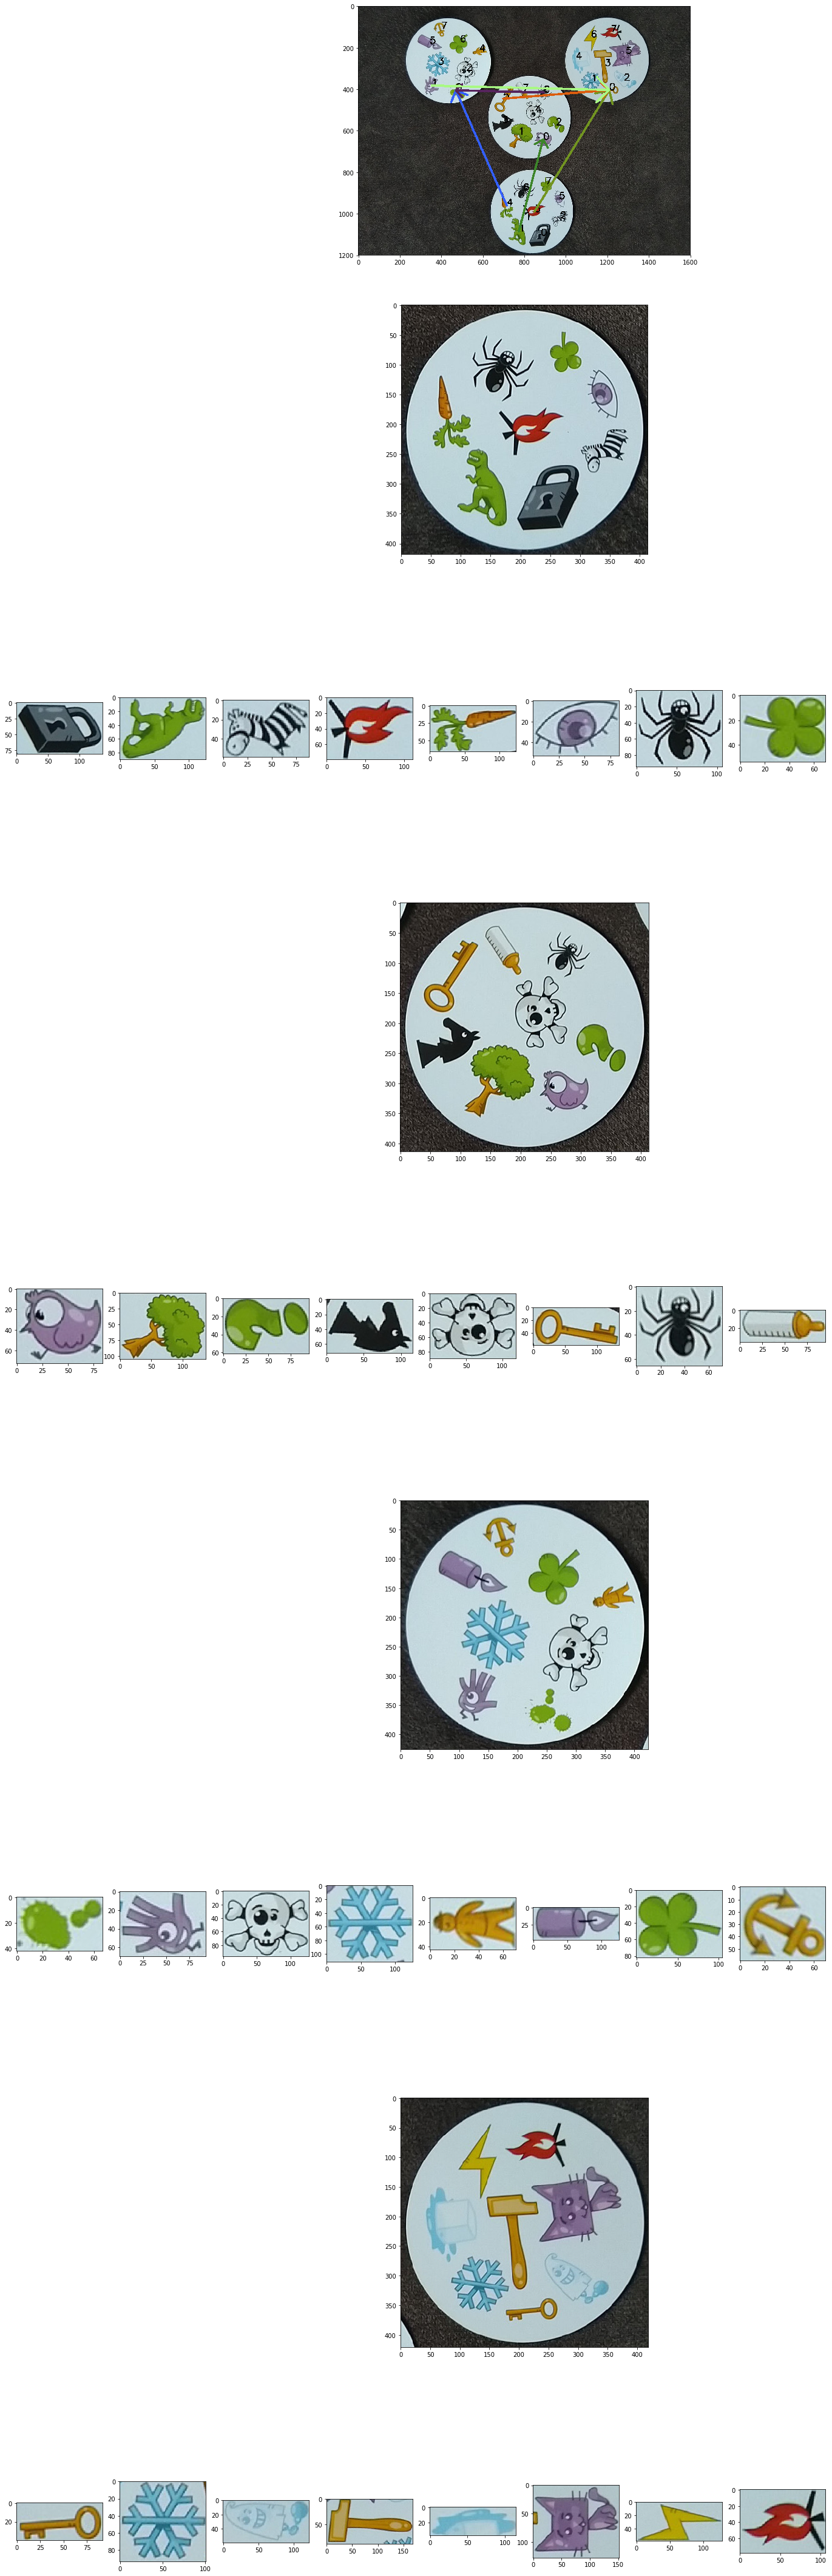

In [3]:
import matplotlib.gridspec as gridspec
import math
import cv2
import numpy as np
from matplotlib import pyplot as plt
import warnings
from random import randint

def coords(contour, i):
    xmin = int(np.amin(contour[:,0,1]))
    xmax = int(np.amax(contour[:,0,1]))
    ymin = int(np.amin(contour[:,0,0]))
    ymax = int(np.amax(contour[:,0,0]))
    return xmin-i, xmax+i, ymin-i, ymax+i
    
def measure(contour):
    xmin, xmax, ymin, ymax = coords(contour, 0)
    return xmax-xmin,ymax-ymin

def draw_arrow(p1, p2):
    cv2.arrowedLine(img_arrows, (int(p1[0]), int(p1[1])), (int(p2[0]), int(p2[1])), (randint(0, 255), randint(0, 255), randint(0, 255)), 9)

# Policz sumę wartości bezwzględnych różnic pomiędzy odpowiadającymi elementami tablic 
def calculate_diff(arr1, arr2):
	return sum(list(map(float.__abs__, list(map(float.__sub__, arr1, arr2)))))

def match_ratio(card1, card2):
	ratios1 = []
	ratios2 = []
	for sign in card1["signs"]:
		ratios1.append(len(sign['pic'][0]) / len(sign['pic'])) 
	for sign in card2["signs"]:
		ratios2.append(len(sign['pic'][0]) / len(sign['pic'])) 
	best_match = (0, 0)
	min_diff = abs(ratios1[0]-ratios2[0])
	for i in range(len(ratios1)):
		# for j in range(i, len(ratios2)):
		for j in range(len(ratios2)):
			if (abs(ratios1[i]-ratios2[j]) < min_diff):
				min_diff = abs(ratios1[i]-ratios2[j])
				best_match = (i, j)
	p1 = card1["signs"][best_match[0]]['coords']
	p2 = card2["signs"][best_match[1]]['coords']
	print('ratios1 = ', ratios1, '\nratios2 = ', ratios2)
	print('best_match = ', best_match, 'min_diff = ', min_diff)
	print('p1 = ', p1, ', p2 = ', p2)
	draw_arrow(p1, p2)

def match_hu(card1, card2):
	hu1 = []
	hu2 = []
	for sign in card1["signs"]:
		hu1.append(cv2.HuMoments(cv2.moments(cv2.cvtColor(sign['pic'], cv2.COLOR_BGR2GRAY))).flatten()) 
	for sign in card2["signs"]:
		hu2.append(cv2.HuMoments(cv2.moments(cv2.cvtColor(sign['pic'], cv2.COLOR_BGR2GRAY))).flatten())
	best_match = (0, 0)
	min_diff = calculate_diff(hu1[0], hu2[0])
	for i in range(len(card1['signs'])):
		for j in range(len(card2['signs'])):
			if(calculate_diff(hu1[i], hu2[i]) < min_diff):
				min_diff = calculate_diff(hu1[i], hu2[i])
				best_match = (i, j)
	p1 = card1["signs"][best_match[0]]['coords']
	p2 = card2["signs"][best_match[1]]['coords']
	print('hu1 = ', hu1, '\nhu2 = ', hu2)
	print('best_match = ', best_match, 'min_diff = ', min_diff)
	print('p1 = ', p1, ', p2 = ', p2)
	draw_arrow(p1, p2)


file = './img/dobble02.jpg'

img_col = cv2.imread(file)
img_arrows = cv2.imread(file)
img = cv2.imread(file, 0)

warnings.simplefilter("ignore")


cards = []
cardsIndexInHierarchy = []

ret,th1 = cv2.threshold(img,175,255,cv2.THRESH_BINARY)
th1 = cv2.erode(th1,np.ones((3,3),np.uint8),iterations = 1)
im2, contours, hierarchy = cv2.findContours(th1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


#wycinanie kart i dodawanie wyciętych do listy 'cards'
for i, h in enumerate(hierarchy[0]):
    if (h[3] == -1):
        xmin, xmax, ymin, ymax = coords(contours[i], 10)
        if (xmax-xmin > 40 or ymax-ymin > 40):
            cards.append({"pic": img_col[xmin:xmax,ymin:ymax], "IndexInHierarchy": i, "signs": []})
            cardsIndexInHierarchy.append(i)
#         cv2.drawContours(img_col, contours, i, (0,0,255), 2)


for card in cards:
    index = hierarchy[0][card["IndexInHierarchy"],2]
    while True:
        cnt = contours[index]
        width, height = measure(contours[index])
        if (width > 40 or height > 40):
            rect = cv2.minAreaRect(cnt)
#             box = cv2.boxPoints(rect)
#             box = np.int0(box)
#             cv2.drawContours(img_col,[box],0,(0,255,0),2)  
            
            rotated = cv2.warpAffine(img_col,  #zdjęcie
                                     cv2.getRotationMatrix2D(rect[0],rect[2],1), #macierz rotacji
                                     img.shape[1::-1]) #wymiary zdjęcia
            
            xmin = int(rect[0][1]-rect[1][1]/2)
            xmax = int(rect[0][1]+rect[1][1]/2)
            ymin = int(rect[0][0]-rect[1][0]/2)
            ymax = int(rect[0][0]+rect[1][0]/2)
            
            cropped = rotated[xmin:xmax,ymin:ymax]
            
            if(xmax-xmin > ymax-ymin): cropped = np.rot90(cropped, 1)
            picDict = {"pic": cropped, "card": index, "coords": rect[0]}
            cv2.putText(img_arrows, str(len(card["signs"])), (int(rect[0][0]), int(rect[0][1])), cv2.FONT_HERSHEY_SIMPLEX,
			1.5, (255, 51, 153), 4) # zapisywanie numeru symbolu na zdjęciu
            card["signs"].append(picDict)

        if (hierarchy[0,index,0] == (-1)): break
        index = hierarchy[0,index,0]

images = [img, th1]


fig = plt.figure(figsize=(30, 80))
gs = gridspec.GridSpec(2*len(cards)+1, 10, wspace=0.2, hspace=0.2)
ax = plt.subplot(gs[0,:])
# ax = plt.subplot(111)	# do dokładnego testowania zdjęcia w konsoli (wyświetlanie tylko jednego)

for i in range(len(cards)):
	for j in range(i, len(cards)):
		if (i!=j): 
			# match_ratio(cards[i], cards[j])
			match_hu(cards[i], cards[j])

# match_hu(cards[0], cards[1])

ax.imshow(cv2.cvtColor(img_arrows, cv2.COLOR_BGR2RGB))

fig.add_subplot(ax)


for j, card in enumerate(cards):
    ax = plt.subplot(gs[2*j+1, :])
    ax.imshow(cv2.cvtColor(card["pic"], cv2.COLOR_BGR2RGB))
    fig.add_subplot(ax)

    for i, sign in enumerate(card["signs"]):
        ax = plt.subplot(gs[2*(j+1), i])
        ax.imshow(cv2.cvtColor(sign["pic"], cv2.COLOR_BGR2RGB))
        fig.add_subplot(ax)
                          
plt.show()


# ax[0].imshow(cv2.cvtColor(img_col, cv2.COLOR_BGR2RGB))
# ax[1].hist(img.flatten(),256,[0,256], color = 'r')
# for i in range(2,4):
#     ax[i].imshow(images[i-2],'gray')

# for i, pic in enumerate(cards):
#     ax[i+4].imshow(cv2.cvtColor(pic, cv2.COLOR_BGR2RGB))
    
# for i, pic in enumerate(signs):
#     ax[i+1].imshow(cv2.cvtColor(pic["pic"], cv2.COLOR_BGR2RGB))
#     ax[i+1].set_title(pic["card"])